# Building MakeMore Part 2
* The bigram model from the last lecture didn't perform very well
* The reason for this is that the model only looks at the previous character to predict the next one
* If we wanted to use the same model to take more characters into account the probability matrix would grow exponentially
* For example with two characters as input, we would have 27*27 rows, with three characters 27*27*27, so basically $27^n$ for n characters
* That means we would need a lot more samples to train the model
* In this lecture we will build a Multi Layer Perceptron Model (MLP) introduced by Bengio et al in 2003, which adresses this problem

## Multi Layer Perceptron Model
* The paper builds a word-level language model, but we will continue with a character level language model
* The approach is as follows: in the paper they take a vocabulary of 17000 words and map each word to a 30 dimensional vector
* In the beginning the word vectors are initialized randomly
* While training the model through backpropagation, the vectors will move around and end up near each other for vectors with similar meaning and drift further apart for vectors with different meanings
* But the modelling approach is the same as we did in the last lecture: they predict the next word given the previous ones and maximize the log likelihood of the training data
* The reason this works is that sentences can be generalized by using the knowledge of semantically similar words (cat,dog), (the,a)

## Network Architecture
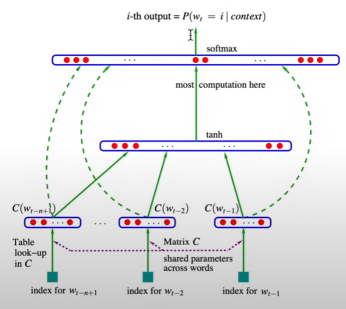
* In the diagram we are taking three previous words and predict the fourth word in a sequence
* With 17000 words, each word becomes an integer between 0 and 16999 which is used as an index into a look-up table containing the respective 30 dimensional vector
* The look-up table naturally is a matrix of dimension 17000x30
* So for the three input words we look-up 3 vectors with 30 values each resulting in 90 values that go into the hidden layer
* The size of the hidden layer is a hyper parameter, i.e. a parameter of the neural network parameters
* A hyper parameter is a design choice for the network and can be varied to yield better results
* Then comes a tanh non-linearity and an output layer that has 17000 neurons to result in the logit for each word
* These logits go into a softmax layer to create a probability distribution for the 17000 words
* So the parameters of the NN are the weights and biases of the output and hidden layer as well as the values in the look-up table

## Implementation
* As in the last lecture we will:
* Read in the words
* Build mappings from/to integers for the characters
* Build the training dataset from the words (three characters in a sequence mapped to the next character as appearing in the words)
* Initialize the look-up table for the embeddings

### Read Words / Create Mapping / Build Trainingset

In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [51]:
len(words)

32033

In [52]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [14]:
import torch
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words[:5]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X[:5])
print(Y[:5])
X.shape

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])
tensor([ 5, 13, 13,  1,  0])


torch.Size([32, 3])

* For the embeddings we will have 27 characters and map them to a two-dimensional vector

## Map to Embedding
* Each character will have a two-dimensional vector representation
* We build a map C from character index to vector

In [76]:
C = torch.randn((27, 2))

* To retrieve a vector corresponding to a character, we will index with the characters number into the look-up table

In [18]:
C[5]

tensor([-1.4815, -0.1134])

* The equivalent mathematical operation is to encode the character index into a one-hot vector an multiply with the embedding matrix

In [17]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.4815, -0.1134])

* For this lecture we will stick with the indexing operation because it is faster
* But we want to pass all samples into the neural net at once
* So we need to index with all samples simulatniously
* This can be done with pytorch by indexing with a tensor of values

In [20]:
C[torch.tensor([5,6,7])]

tensor([[-1.4815, -0.1134],
        [ 0.7700, -0.6174],
        [-0.1531,  1.2487]])

* And indexing with all three characters from all samples works as well

In [23]:
C[torch.tensor(([1,1,2], [5,6,1]))]

tensor([[[ 2.1161, -0.5470],
         [ 2.1161, -0.5470],
         [ 0.8414, -0.4275]],

        [[-1.4815, -0.1134],
         [ 0.7700, -0.6174],
         [ 2.1161, -0.5470]]])

* As such, we can just index with all samples at once to get all embeddings from the training set

In [25]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

### Creating the hidden Layer
* Like in the last lecture, we will initialize all the weights for the first layer by drawing from the normal distribution
* This weights matrix will have a dimension of 6 (two dimensions for each of the three characters) and we choose 100 as the hyper parameter to be the number of outputs
* This time we will add also 100 bias values to the outputs

In [27]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

### Reshaping the Embeddings Tensor

* To feed the embeddings into the first layer, we need to put the three embeddings of each sample into one row vector, so it is compatible with the number of weights in the weights matrix
* Currently we have emb.shape == n (number_of_samples), 3 (block size), 2 (embedding dimensions) and for each neuron 6 weights

#### Cat
* We can use the ```cat``` function from pytorch to do this

In [35]:
torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1)

tensor([[ 0.1384,  0.7111,  0.1384,  0.7111,  0.1384,  0.7111],
        [ 0.1384,  0.7111,  0.1384,  0.7111, -1.4815, -0.1134],
        [ 0.1384,  0.7111, -1.4815, -0.1134, -0.2627,  0.2443],
        ...,
        [-0.3958,  0.2523, -0.3958,  0.2523, -0.3169,  0.5371],
        [-0.3958,  0.2523, -0.3169,  0.5371, -0.3958,  0.2523],
        [-0.3169,  0.5371, -0.3958,  0.2523, -0.5168,  1.5400]])

#### Unbind

* But this will not generalize, if we change the context size (or block size as it is later called)
* A more generalizable function is ```unbind```, which just removes a dimension from the tensor and puts the elements into its own tensor
* The result is multiple tensors of dimensionality matching the original one with the unbound dimension removed
* And there will be as many tensors as the dimension had elements
* Those elements can then be concatenated

In [63]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[ 0.1384,  0.7111,  0.1384,  0.7111,  0.1384,  0.7111],
        [ 0.1384,  0.7111,  0.1384,  0.7111, -1.4815, -0.1134],
        [ 0.1384,  0.7111, -1.4815, -0.1134, -0.2627,  0.2443],
        ...,
        [-0.3958,  0.2523, -0.3958,  0.2523, -0.3169,  0.5371],
        [-0.3958,  0.2523, -0.3169,  0.5371, -0.3958,  0.2523],
        [-0.3169,  0.5371, -0.3958,  0.2523, -0.5168,  1.5400]])

#### View
* A more efficient way than ```unbind``` and ```cat``` is to use a ```view```
* A ```view``` doesn't copy the tensor, but changes some attributes to make it look different

In [71]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [66]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [67]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

* The underlying storage of a tensor doesn't change
* It is always a linear storage of the elemnts

In [70]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

* A view only manipulates some attributes of the tensors, called storage offset, strides and shapes
* A good blog post about these tensor internals can be found here: http://blog.ezyang.com/2019/05/pytorch-internals/
* We can now reshape emb to be compatible with the weights W
* By specifying -1 as the first dimension, this dimension will be computed based on the others

### Forward Pass through hidden Layer
* Now we have everything to pass through the hidden layer and compute the output
* Training Set X
* Embeddings C[X]
* Weights and biases W1 and b1
* Reshaping of embeddings to concatenate all vectors from a block/context
* Finally we also compute the tanh non-linearity

In [81]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

#### Validate the Broadcast Operation
* The addition of b1 involves a broadcasting operation
* We will apply the broadcasting rules to check whether it behaves as intended
* For the rules, check https://pytorch.org/docs/stable/notes/broadcasting.html

In [84]:
(emb.view(-1,6) @ W1).shape

torch.Size([228146, 100])

In [85]:
b1.shape

torch.Size([100])

In [87]:
# Last dimension matches and first dimension has one empty size -> broadcastable
# 228146  100
#         100

In [88]:
# Empty dimension filled with one
# 228146 100
#      1 100

In [89]:
# Dimensions made equal by broadcasting the one across the 228146 entries
# 228146 100
# 228146 100

* This is what we intended, as each row is the activation a all neurons in the hidden layer for one sample
* The entries in b1 correspond to the respective neurons in the layer
* broadcasting will replicate the bias vector across all rows

### Creating the output Layer and forward through it
* Inputs to the layer are the 100 outputs of the hidden layer
* Outputs are the 27 possible characters that may come next
* The output values are logits
* The logits will be exponentiated to get counts
* Counts will be normalized to get a probability distribution

In [91]:
W2 = torch.randn((100, 27)).float()
b2 = torch.randn((27)).float()

In [94]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [104]:
counts = logits.exp()

In [107]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [108]:
prob[0].sum()

tensor(1.0000)

### Compute Loss of Prediction
* Labels are the expected next character for all samples
* The loss is the negative log likelihood
* Likelihood is the product of all probabilities of the expected next characters
* Log likelihood is the log of the likelihood, which is equivalent with the sum of logs of the probabilities, i.e.
  
  $log(p1*p2*p3\cdots) \equiv  log(p1) + log(p2) + log(p3) \cdots$
* Negative so we can minimize it using gradient decent

In [133]:
nll = -prob[torch.arange(0, Y.size()[0]), Y].log().mean()
nll

tensor(15.5501)

### Summary

In [135]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [147]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [182]:
emb = C[X]
h = (emb.view(-1, 6) @ W1 + b1).tanh()
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(Y.size()[0]), Y].log().mean()
loss

tensor(3.0065, grad_fn=<NegBackward0>)

#### Using Cross Entropy to calculate Loss

* The operation of calculating the loss between logits and labels is called cross entropy
* This is done routinely in classification problems
* There is a function for that in pytorch, so we don't do it manually
* The reason to use the library function is that pytorch will cluster all the operations into one fused kernel and create fewer tensors
* The derivative of a more complex mathematical expression can analytically be represented as a simpler expression than calculating the derivatives of all expressions involved, so the backward pass is also more efficient

In [162]:
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

* Another reason is that pytorch behaves numerically stable
* What that means can be demonstrated by an example
* When absolute logit values become very large like -100 or 100 we may run into trouble:

In [167]:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

* The reason for the ```nan``` in the fourth place has it's root in the exp() operation
* Let's look at counts to see what happened

In [169]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

* Taking $e$ to the power of a very negative number results in a value very close to zero, so it is still well-behaved
* When we take $e$ to the power of a very positive number like 100 however, the result will run out of dynamic range and become ```inf```
* To circumvent this from happening, we observe that adding or subtracting the same number from all logits will not change the probabilities
* Pytorch will internally find the largest logit and subtract it from the others, so the largest logit will become 0 and the rest negative
* This is all done automatically so we don't have to take care of it

In [170]:
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

* In summary using ```cross_entropy``` will give as more efficient forward and backward passes as well a be numerically well-behaved

In [172]:
emb = C[X]
h = (emb.view(-1, 6) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

### Training the Neural Net on the first five Words
* Initially we built the training set on only five words resulting in 32 samples

In [109]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [110]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [220]:
# number of parameters in total
sum(p.nelement() for p in parameters)

3481

In [189]:
# initialize parameters to have grads
for p in parameters:
    p.requires_grad = True

In [192]:
for _ in range(1000):
    # forward pass
    emb = C[X]
    h = (emb.view(-1, 6) @ W1 + b1).tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient descent
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.2561369836330414


* The loss decreases almost to zero
* This very low loss is due to the fact that we are training on only 32 examples with a NN of 3481 parameters
* We are overfitting the net to our training set
* The reason why we are not reaching zero is that even in the training set, the same block sometimes is followed by different labels
* Therefore such blocks cannot be assigned one label with 100% probability
* We can observe this by looking at the maximum value along the first dimension of the logits, which are the predictions for the labels

In [193]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3348, 17.7906, 20.6013, 20.6118, 16.7355, 13.3348, 15.9986, 14.1725,
        15.9149, 18.3614, 15.9397, 20.9265, 13.3348, 17.1088, 17.1319, 20.0600,
        13.3348, 16.5889, 15.1016, 17.0579, 18.5864, 15.9672, 10.8740, 10.6873,
        15.5056, 13.3348, 16.1793, 16.9743, 12.7427, 16.2007, 19.0848, 16.0194],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

* Comparing with the labels, we see that we get almost the same results, except in a few places, e.g. for the first sample

In [206]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

* The first sample was '...' for the beginning of a word
* But as we have multiple words, multiple characters may follow '...', so none of the possible values will receive 100% probability
* In this case 'e' has the highest probability

In [209]:
itos[Y[0].item()]

'e'

### Training the Neural Net on all Words
* The full list of words has 32033 entries, resulting in 228146 samples

In [15]:
import torch
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(len(words))
X.shape

32033


torch.Size([228146, 3])

* Reinitialize the parameters of the NN from the random distribution

In [112]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

* Enable gradients on the parameters

In [113]:
# initialize parameters to have grads
for p in parameters:
    p.requires_grad = True

* Forward, backward and descent

In [14]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = (emb.view(-1, 6) @ W1 + b1).tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient descent
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.084484100341797
15.776532173156738
14.833340644836426
14.002605438232422
13.253263473510742
12.57991886138916
11.983102798461914
11.47049331665039
11.051855087280273


### Increasing Training Speed
* To increase the forward and backward passes in each iteration, people usually perform those computations of smaller batches from the training set
* We can pick 32 samples randomly from the range of samples in X

In [227]:
torch.randint(0, X.shape[0], (32,))

tensor([ 49728, 109826, 166413,  94678,  10603,  92838, 111347, 122649, 204555,
         17520,  19068, 202821, 196777, 197638,  52091, 222416, 142747, 201327,
         71921,  94975, 154428, 213381, 162023,  29463,  35822, 192353,  95584,
        176702,  87712, 144784, 117200,  43140])

* In the training runs, we pick different 32 samples per run

In [164]:
def reset():
    global g, C, W1, b1, W2, b2, parameters
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

3.5867679119110107


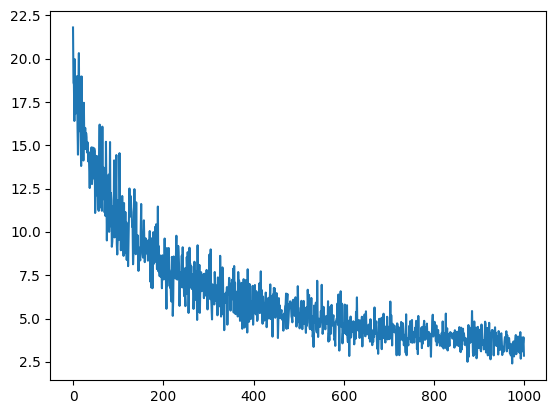

In [230]:

def train_with(step_size):
    losses = []
    iterations = []
    for i in range(1000):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (32,), generator=g)
        
        # forward pass
        emb = C[X[ix]]                                # only pick the minibatch of samples
        h = (emb.view(-1, 6) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])         # also pick the labels corresponding to the minibatch
        iterations.append(i)
        losses.append(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # gradient descent
        for p in parameters:
            p.data += -step_size * p.grad
    plt.plot(iterations, losses)
    # print the global loss, not the loss of the minibatch
    # One forward pass with the whole dataset
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
reset()
train_with(0.01)

* Using minibatches to estimate the gradient will result in a less precise gradient direction
* But it is much better to take an approximate gradient and do more steps than using an exact gradient and doing less steps
* Question: explain why the gradient is less precise in a more rigorous way
* The printed loss above is the loss for the minibatch
* We need to look at the overall loss for the full training set

In [174]:
emb = C[X]
h = (emb.view(-1, 6) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

3.5867679119110107

* If you run the training a couple of times and check the resulting overall loss, you might notice that the loss sometimes increases
* The step size in gradient descent might be off, because we guessed it
* It might overshoot the minimum and increase again

### Determining the Step Size

* To find a good step size, we will first reset the parameters

* A too small step size would converge too slow

17.170482635498047


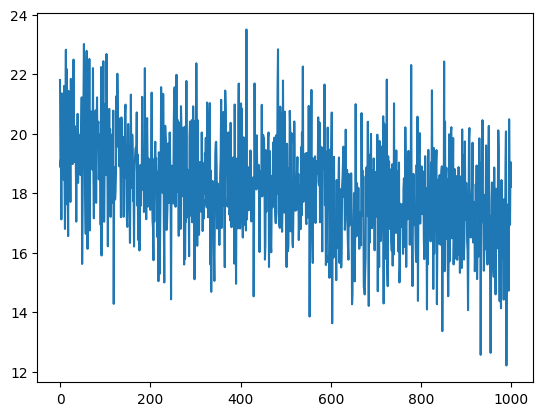

In [231]:
reset()
train_with(0.0001)

* Let's try one order of magnitude higher

10.735797882080078


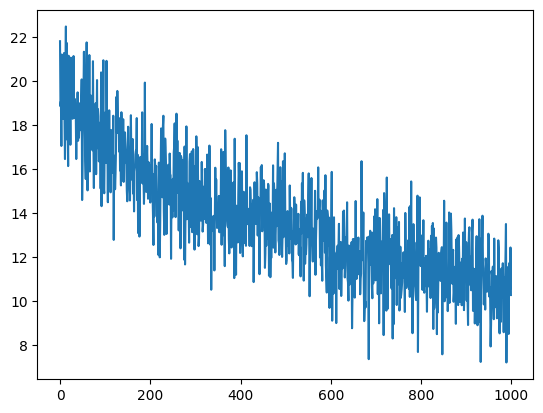

In [232]:
reset()
train_with(0.001)

* Seems to be decreasing better, but still quite slowly
* It is a good low range
* Now we find a step size at which the loss explodes

4.251540184020996


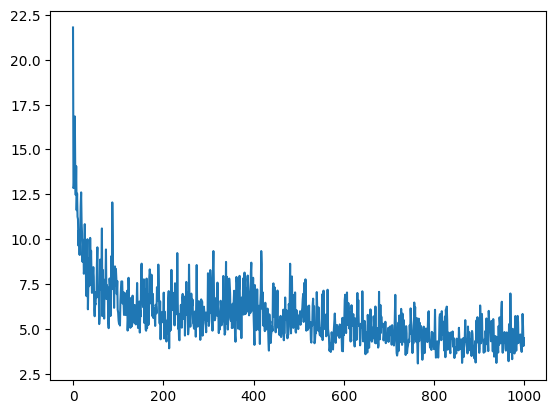

In [233]:
reset()
train_with(1)

* Looks better, but becomes more unstable
* Let's try even worse

48.25004959106445


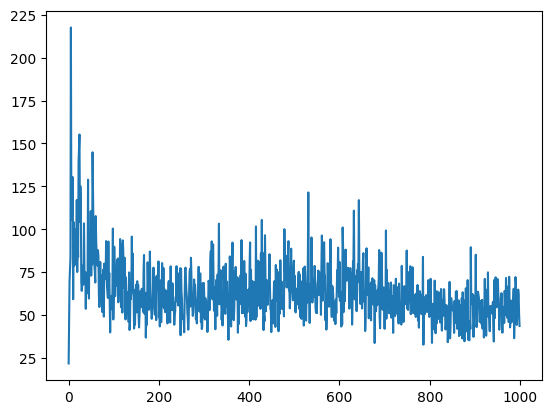

In [234]:
reset()
train_with(10)

* This doesn't optimize at all
* It seems that the right learning rate is somewhere between -0.001 and -1
* We will test the different learning rates in that range, but we will increase the step size exponentially and not go through the step sizes linearily

In [180]:
lre = torch.linspace(-3, 0, 1000)  # linear list of the range of exponents between 10^(-3)=0.001 and 10^0=1
lrs = 10**lre

* We need to modify the training to make use of the variable step sizes per iteration

9.347137451171875


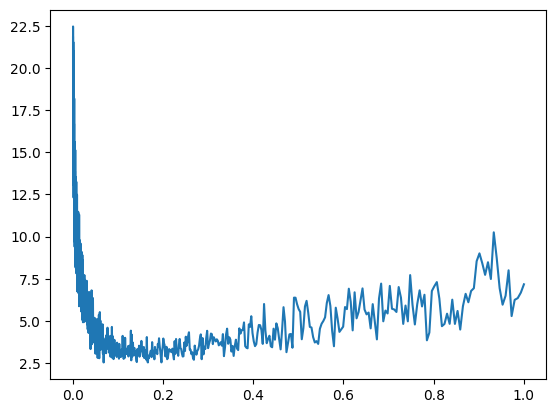

In [224]:
lossi = []                                        # loss for learning rate i
lri = []                                          # learning rate index
def train():
    global lossi, lri
    for i in range(1000):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (32,), generator=g)
        
        # forward pass
        emb = C[X[ix]]                                # only pick the minibatch of samples
        h = (emb.view(-1, 6) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])         # also pick the labels corresponding to the minibatch
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # gradient descent
        lr = lrs[i]
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        lri.append(lr)
        lossi.append(loss.item())
        
    plt.plot(lri, lossi)
    # print the global loss, not the loss of the minibatch
    # One forward pass with the whole dataset
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
reset()
train()

* Remember that the X axis is non-linearly spaced

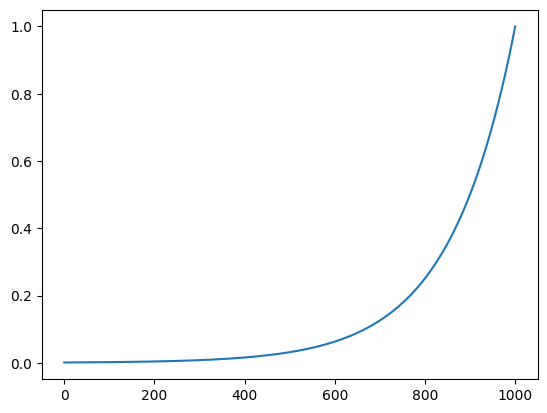

In [182]:
plt.plot(torch.linspace(0, 1000, 1000), lri)

* Looking at the loss at each iteration, we can see that it decreases only slightly for the bulk of step sizes, which increase until 0.2 for the first 800 step sizes
* The loss decreases quite stable until the step size of 0.2, where there is a valley in the loss plot
* After the valley, the loss becomes quite unstable
* The X axis of the loss plot describes the actual step size
* If we change the X axis to be the exponent of the learning rate, the X axis will become linearly spaced

9.347137451171875


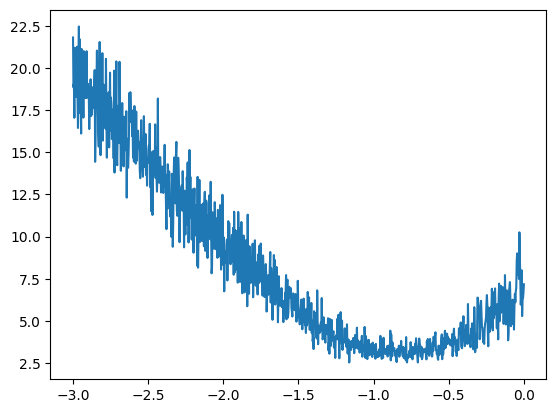

In [207]:
lossi = []
lri = []
def train():
    global lossi, lri
    for i in range(1000):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (32,), generator=g)
        
        # forward pass
        emb = C[X[ix]]
        h = (emb.view(-1, 6) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # gradient descent
        lr = lrs[i]
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        lri.append(lre[i])                        # store the exponent instead of the actual learning rate
        lossi.append(loss.item())
        
    plt.plot(lri, lossi)
    # print the global loss, not the loss of the minibatch
    # One forward pass with the whole dataset
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

reset()
train()

* Now we can see that a good learning rate is roughly at -1.0, which is $10^{-1}=0.1$
* QUESTION: shouldn't we do 1000 iterations for one learning rate and not change the learning rate per iteration?
* Now that we determined a good learning rate, we can set it for all iterations

2.6530582904815674


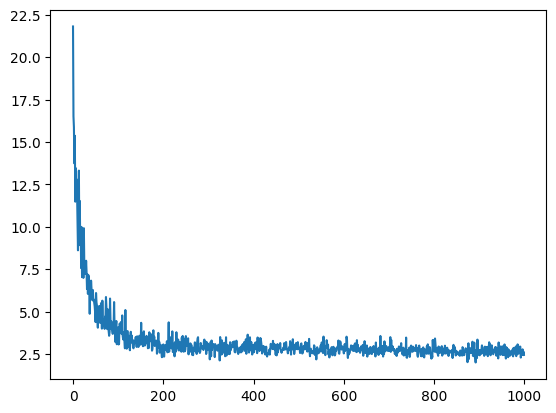

In [235]:
reset()
train_with(0.1)

* Adding a few training runs to get a better loss

2.5870351791381836


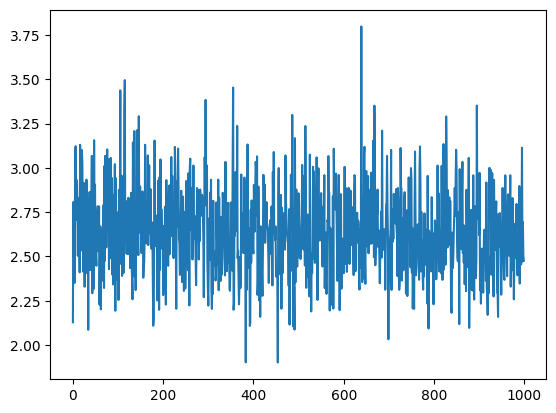

In [236]:
train_with(0.1)

2.5258612632751465


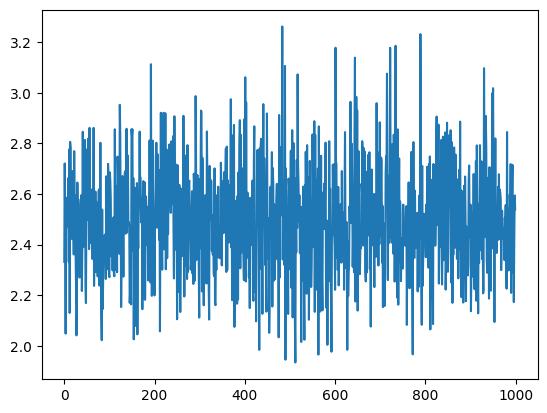

In [245]:
train_with(0.1)

* If the loss decrease becomes unstable at rougly 2.4, we can decrease the learning rate to step more carefully
* Decreasing the learning rate at later training stages is called *learning rate decay*

2.389035701751709


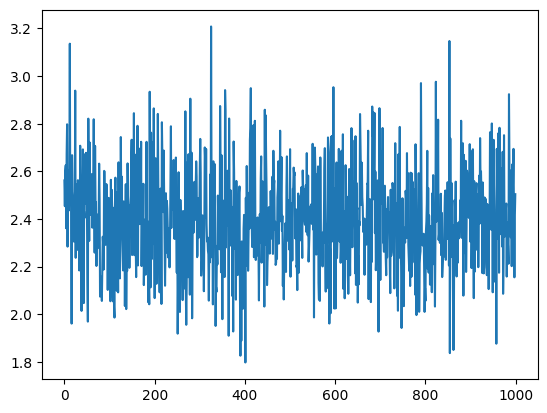

In [261]:
train_with(0.01)

* We can see that the training loss becomes already better when compared to the bigram model from last lecture, which was 2.45

### Avoiding Overfitting
* The bigram model loss was around 2.45, while the MLP model achieved roughly 2.39
* It is easy to get very low loss values, when increasing the parameter count of the models
* But large parameter counts may overfit the model to the training data
* Overfitting means that we get almost perfect results for the training data, but not so much for unseen data
* The standard counter measure in the field against overfitting is to split the training data into three sets:
    1. The **training split** (roughly **80%** of the training data)
       - Used to train the model with gradient descent
    1. The **dev/validation split** (roughly **10%** of the training data)
       - Used to optimize hyper-parameters like hidden layer size or dimensions of embeddings
    1. The **test split** (roughly **10%** of the training data)
       - Evaluate the performance of the model, but using it sparsely as overuse of the test split might result in training on the test split

#### Creating the 3 Splits

In [76]:
import torch
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))   # number of words that make up 80% of the words
n2 = int(0.9*len(words))   # number of words that make up 10% of the words

Xtr = X[0:n1]              # take 80% of X
Ytr = Y[0:n1]              # take 80% of Y
Xdev = X[n1:n2]            # take the next 10% of X
Ydev = Y[n1:n2]            # take the next 10% of Y
Xtest = X[n2:]             # take the last 10% of X
Ytest = Y[n2:]             # take the last 10% of Y


In [54]:
Xtr.shape, Xdev.dtype, Ytr.shape, Ydev.dtype

(torch.Size([25626, 3]), torch.int64, torch.Size([25626]), torch.int64)

### Train and Compare Training Loss vs. Dev Loss
* create training function that only works on training set
* Check the loss of the minibatch

In [279]:
def train_split():
    for i in range(10000):                                           # increase iterations
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
        
        # forward pass
        emb = C[Xtr[ix]]                                            # Only work on training set
        h = (emb.view(-1, 6) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])                     # Only work on training set
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # gradient descent
        lr = 0.01
        for p in parameters:
            p.data += -lr * p.grad
        
    print(loss.item())

reset()
train_split()

2.1269311904907227


* Now check the loss of the dev set

In [280]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4345, grad_fn=<NllLossBackward0>)

* We can also compare to the loss on the full training set

In [281]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4027, grad_fn=<NllLossBackward0>)

* The loss on the two sets are about equal, so we see that the model is not overfitting and not just memorizing the data
* We can say that we are underfitting, so when we increase the scale of the NN, we expect to get performance improvements

### Increase Hyperparameters
* We will first increase the number of neurons of the hidden layer from 100 to 300

In [68]:
def reset_enlarge():
    global g, C, W1, b1, W2, b2, parameters
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 300), generator=g)         # increase the node count of the hidden layer
    b1 = torch.randn(300, generator=g)              # increase biases accordingly 
    W2 = torch.randn((300, 27), generator=g)        # increase inputs to output layer accordingly
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    print(sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True

In [69]:
reset_enlarge()

10281


* We now have 10k parameters vs. 3k before
* Also we will train for more iterations with the roughly optimal step size again

In [79]:
stepi = []
lossi = []
def train_split(step_size):
    for i in range(30000):                                           # increase iterations even more
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (32,))
        
        # forward pass
        emb = C[Xtr[ix]]
        h = (emb.view(-1, 6) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # gradient descent
        lr = step_size
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        stepi.append(i)
        lossi.append(loss.item())
    print(loss.item())

In [83]:
reset_enlarge()
train_split(0.1)

10281
1.923816442489624


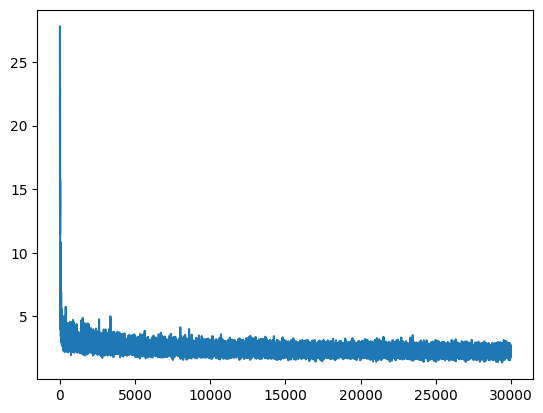

In [81]:
plt.plot(stepi, lossi)

* There is a bit of thickness to the plot because of the minibatch optimization, which adds noise
* Compare the loss of the full training set to the loss of the dev set again to see if we achieve a similar loss on an unseen set

In [73]:
def tr_loss():
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print(loss.item())

In [74]:
def dev_loss():
    emb = C[Xdev]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print(loss.item())

In [84]:
tr_loss()
dev_loss()

2.156755208969116
2.331932306289673


* We want to achieve a better result when compared to the model with 3k parameters, because we were underfitting
* We will train some more

In [89]:
train_split(0.1)

2.107783079147339


* Check the losses again

In [90]:
tr_loss()
dev_loss()

2.0369632244110107
2.3389127254486084


* It doesn't go down much, the reason might be
  1. The model is big and requires many training steps
  1. The batch size is too small, so the gradient might be too noisy
  1. The dimensionality of the embeddings are too small, so the model has to cram too many characters into a small space
  1. We might lower the step size and apply learning rate decay

In [91]:
train_split(0.05)

1.7811778783798218


In [92]:
tr_loss()
dev_loss()

1.8495482206344604
2.1777522563934326


* We are getting better for the dev set, but not by huge margins
* Let's have a look at the embeddings

### Visualizing Embeddings

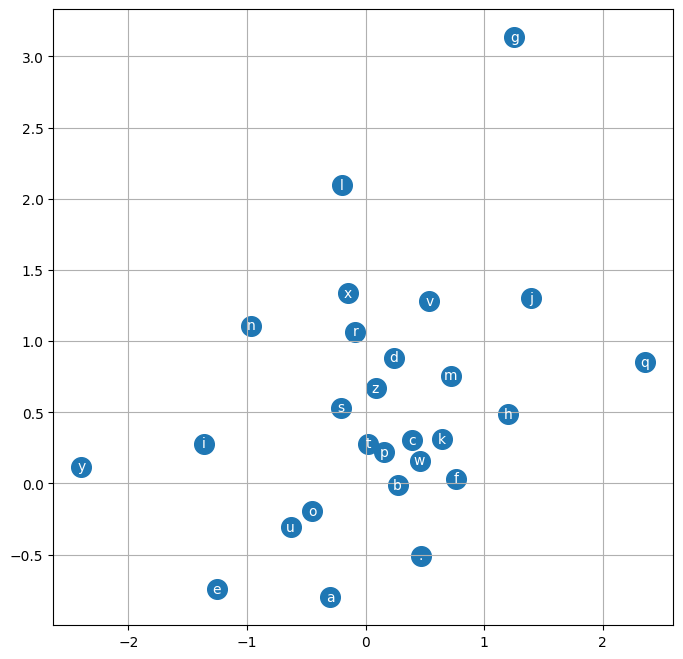

In [93]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

* The embeddings seem to make sense and not be random
* We observe that the vowels are clustered, 'q' is somhow an outlier as well as 'y' and '.'
* We can try to give more dimensions to the embeddings to improve performance
* Also decrease the size of the hidden layer again

In [104]:
def reset_enlarge_embeddings():
    global g, C, W1, b1, W2, b2, parameters
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g)          # Let's try 10-dimensional embeddings
    W1 = torch.randn((30, 200), generator=g)
    b1 = torch.randn(200, generator=g)
    W2 = torch.randn((200, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    print(sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True

* And we need to adjust the view to match the new dimensions
* Also increase the iterations
* Also we will use the log of the loss, as we usually get a hockey stick shape and log will squash the vertical part to make the rest more visible

In [99]:
stepi = []
lossi = []

In [103]:
def train_split_large_emb(step_size):
    for i in range(50000):                                           # increase iterations even more
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (32,))
        
        # forward pass
        emb = C[Xtr[ix]]
        h = (emb.view(-1, 30) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # gradient descent
        lr = step_size
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        stepi.append(i)
        lossi.append(loss.log10().item())
    print(loss.item())

In [105]:
reset_enlarge_embeddings()
train_split_large_emb(0.1)

11897
1.9751936197280884


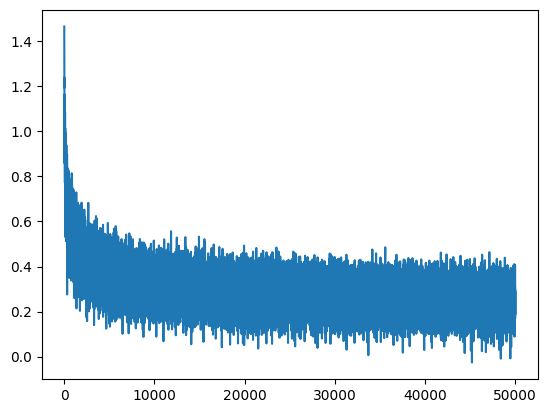

In [106]:
plt.plot(stepi, lossi)

* Also adjust the loss calculations because we hard-coded the embedding view

In [109]:
def tr_loss():
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print(loss.item())

In [108]:
def dev_loss():
    emb = C[Xdev]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print(loss.item())

In [110]:
tr_loss()
dev_loss()

1.8632110357284546
2.414909839630127


* Do learning rate decay by a factor of 10

In [111]:
train_split_large_emb(0.01)

1.4420937299728394


In [112]:
tr_loss()
dev_loss()

1.6410549879074097
2.2203714847564697


* The training loss and the dev loss seem to slowly diverge, which might be a sign of overfitting

In [118]:
train_split_large_emb(0.01)

1.3790291547775269


In [119]:
tr_loss()
dev_loss()

1.6121999025344849
2.2603745460510254


* In a real setting, you would try different experiments to find good hyper params
* At the end you would run the NN on the test set only once and then report that number in your paper

### Final Run

* The last setup involved 500000 iterations
* Step size 0.1 for the first 100000 iterations, then decay to 0.01

In [122]:
stepi = []
lossi = []
def train_final():
    for i in range(500000):                                           # increase iterations even more
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (32,))
        
        # forward pass
        emb = C[Xtr[ix]]
        h = (emb.view(-1, 30) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # gradient descent
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        stepi.append(i)
        lossi.append(loss.log10().item())
    print(loss.item())

In [123]:
reset_enlarge_embeddings()

11897
1.6226705312728882


In [126]:
train_final()

1.4831448793411255


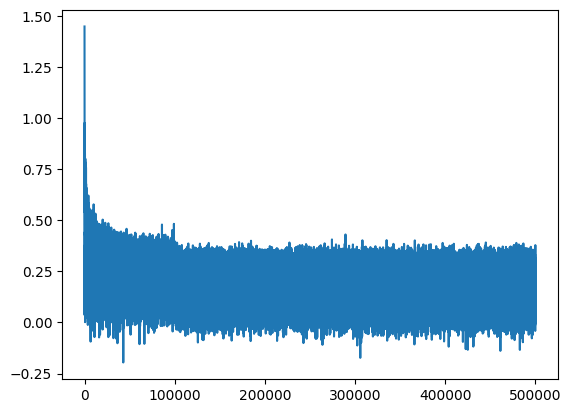

In [127]:
plt.plot(stepi, lossi)

In [129]:
tr_loss()
dev_loss()

1.5255135297775269
2.4045770168304443


* The challenge is to beat the achieved number, by e.g.:
* Change the number of neurons in the hidden layer
* Change the number of dimensionality of the embedding
* Change the number of characters that are feeding in (block_size currently 3)
* Number of iterations in the training run
* Change the learning rate decay
* Change batch size 

* Finally: read the bengio paper, which also has some ideas on how to improve the performance

### Sampling from the Model

In [131]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

eria.
kayah.
serra.
dariah.
remy.
stengridget.
charieline.
milah.
leigh.
estlyannedy.
korra.
ami.
sha.
vigailaness.
jailee.
jordelphira.
brence.
ryanaliyah.
yulishayvenda.
halianaya.
